SINDy approach for Lotka-Volterra Equation
https://docs.sciml.ai/DiffEqParamEstim/stable/getting_started/
DiffEqParamEstim.jl を使用して常微分方程式のパラメーターを推定する。

In [1]:
using DifferentialEquations, RecursiveArrayTools, DiffEqParamEstim
using Optimization, ForwardDiff, OptimizationOptimJL, OptimizationBBO
using DataDrivenSparse
using Plots
using Random
Random.seed!(1)
T = 10.0
N = 1000
η = T/N
std = 0.1
train_itr = 10000
#init_std = 0.5
init_std = 2e-1

0.2

Lotka-Volterra方程式の定義

In [2]:
# System of ODEsの定義
function system!(du, u, p, t)
    du[1] = dx = p[1] * u[1] - p[2] * u[1] * u[2]
    du[2] = dy = -p[3] * u[2] + p[4] * u[1] * u[2]
end

u0 = [1.0; 1.0]
tspan = (0.0, T)
p = [1.5, 1.0, 3.0, 1.0]
prob = ODEProblem(system!, u0, tspan, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 1.0
 1.0

合成データ生成(a=1.5)：ODE の結果を行列(2X1000)に変換する。

In [3]:
sol = solve(prob, Tsit5())
t = collect(range(0, stop = T, length = N))
using RecursiveArrayTools # for VectorOfArray
randomized = VectorOfArray([(sol(t[i]) + init_std*randn(2)) for i in 1:length(t)])
data = convert(Array, randomized)

2×1000 Matrix{Float64}:
 0.985883  0.843747  1.24343  1.36601   …  0.92579  1.03789   1.16409
 1.1063    1.4716    1.01436  0.776726     1.07997  0.593703  0.480806

合成データのプロット
p = [1.4, 1.0, 3.0, 1.0]に変更する

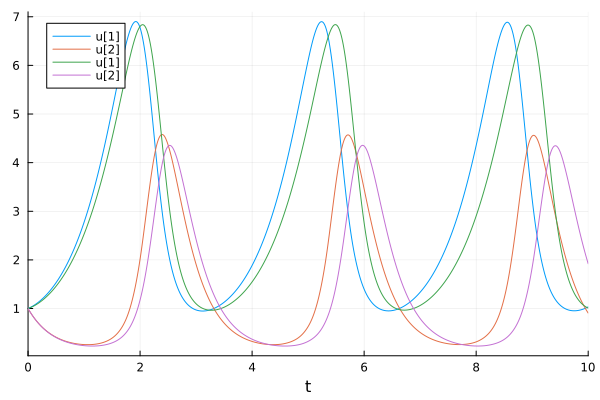

In [4]:
newprob = remake(prob, p = [1.4, 1.0, 3.0, 1.0])
newsol = solve(newprob, Tsit5())
plot(sol)
plot!(newsol)

微分方程式の数値解とデータ間の誤差（L2損失（平均二乗誤差）を用いた損失）を最小化するパラメータを見つけるための費用関数を構築する。
（※）経験則としては、Optimization.AutoForwardDiff()はパラメータと状態が 100 未満の場合に使用し、それ以上の場合はOptimization.AutoZygote()を使用する。


パラメータ最適化の範囲を指定する。LBFGS法を選択する。計算時間分21秒。

In [5]:
lower = [0.5, 0.5, 0.5, 0.5] 
upper = [3.0, 3.0, 3.0, 3.0] 
p_init = [1.3, 0.8, 2.8, 1.2]
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data), Optimization.AutoForwardDiff(), maxiters = train_itr, verbose = false)
optprob = Optimization.OptimizationProblem(cost_function, p_init, lb = lower, ub = upper)
result_bfgs = solve(optprob, LBFGS())

retcode: Success
u: 4-element Vector{Float64}:
 1.5033420958186332
 1.0027254341424865
 2.9912384244188153
 0.9957887631786809

損失関数（L2ロス）計算の際にdiffer_weightとdata_weightによって差異とデータ重みの比率を調整する。
モデルの出力とデータ間の差異と、データ点間不一致に等しく重要視する場合（基本設定）：differ_weight = 0.5とdata_weight = 0.5
データの信頼性が高い場合: differ_weight = 0.3とdata_weight = 0.7
予測の平滑性を重視する場合: differ_weight = 0.7とdata_weight = 0.3

In [6]:
lower = [0.5, 0.5, 0.5, 0.5] 
upper = [3.0, 3.0, 3.0, 3.0] 
p_init = [1.3, 0.8, 2.8, 1.2]
cost_function = build_loss_objective(prob, Tsit5(),L2Loss(t, data, differ_weight = 0.3,data_weight = 0.7),
    Optimization.AutoForwardDiff(),maxiters = train_itr, verbose = false)
#
optprob = Optimization.OptimizationProblem(cost_function, p_init, lb = lower, ub = upper)
result_bfgs = solve(optprob, BFGS())

retcode: Success
u: 4-element Vector{Float64}:
 1.5033445461035864
 1.0027245309993567
 2.9912303822423
 0.9957859233395273

損失関数（L2ロス）計算の際にdiffer_weightとdata_weightによって差異とデータ重みの比率を調整する。
モデルの出力とデータ間の差異と、データ点間不一致に等しく重要視する場合（基本設定）：differ_weight = 0.5とdata_weight = 0.5
計算時間10秒

In [7]:
lower = [0.5, 0.5, 0.5, 0.5] 
upper = [3.0, 3.0, 3.0, 3.0] 
p_init = [1.3, 0.8, 2.8, 1.2]
cost_function = build_loss_objective(prob, Tsit5(),L2Loss(t, data, differ_weight = 0.5,data_weight = 0.5),
    Optimization.AutoForwardDiff(),maxiters = train_itr, verbose = false)
#
optprob = Optimization.OptimizationProblem(cost_function, p_init, lb = lower, ub = upper)
result_bfgs = solve(optprob, BFGS())
println(result_bfgs.minimizer)

[1.5033478081191691, 1.0027233257092476, 2.991219675616454, 0.9957821422792579]


グラフ出力

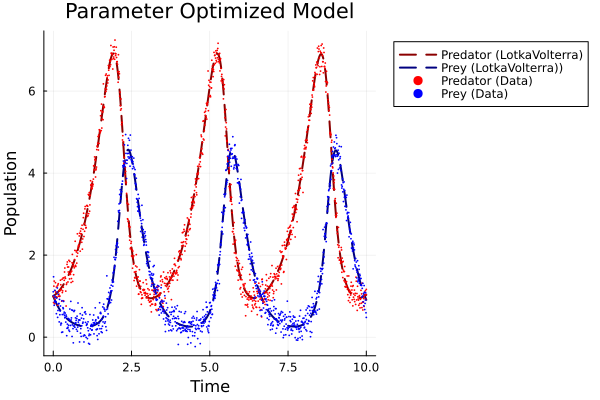

In [9]:
#
optprob = ODEProblem(system!, u0, tspan, result_bfgs.minimizer)
optsol = solve(optprob, Tsit5())

# 数値解のプロット（線の色を濃い赤色と藍色に指定）
p1 = plot(t, [optsol(t)[1] for t in t], label = "Predator (LotkaVolterra)", title = "Parameter Optimized Model", xlabel = "Time", ylabel = "Population", legend = :outertopright, linewidth = 2, linecolor = :darkred,linestyle=:dash)
plot!(t, [optsol(t)[2] for t in t], label = "Prey (LotkaVolterra))", linewidth = 2, linecolor = :navy,linestyle=:dash)

# データポイントの追加（マーカー色を赤色と青色に指定、枠線も同じ色で指定）
scatter!(t, [data[1, i] for i in 1:length(t)], label = "Predator (Data)", markercolor = :red, markersize = 1, markerstrokecolor = :red, markerstrokewidth = 0.5)
scatter!(t, [data[2, i] for i in 1:length(t)], label = "Prey (Data)", markercolor = :blue, markersize = 1, markerstrokecolor = :blue, markerstrokewidth = 0.5)

plot(p1,layout = (1, 1), size = (700, 400))
display(p1)

プロット

In [130]:
savefig("LtkV_OPtimized.png")

"c:\\Users\\kmako\\Dropbox\\JuliaDocs\\6_Modelbased_DeepLearning\\Lotka_Volterra\\LtkV_OPtimized.png"

データポイントの散布図のみを出力する

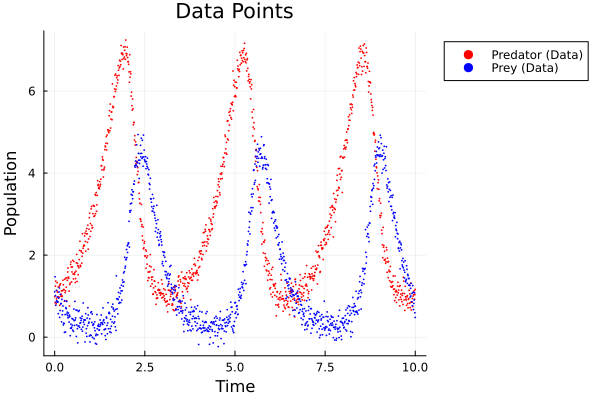

"c:\\Users\\kmako\\Dropbox\\JuliaDocs\\6_Modelbased_DeepLearning\\Lotka_Volterra\\LtkV_Data.png"

In [10]:
# データポイントのみをプロット
p1 = scatter(t, [data[1, i] for i in 1:length(t)], label = "Predator (Data)", markercolor = :red, markersize = 1, markerstrokecolor = :red, markerstrokewidth = 0.5, title = "Data Points", xlabel = "Time", ylabel = "Population", legend = :outertopright)

scatter!(t, [data[2, i] for i in 1:length(t)], label = "Prey (Data)", markercolor = :blue, markersize = 1, markerstrokecolor = :blue, markerstrokewidth = 0.5)

# プロット設定と表示
plot(p1, size = (700, 400))
display(p1)
savefig("LtkV_Data.png")


DataDrivenDiffEqパッケージに基づいたデータ駆動アプローチを用いて、データから微分方程式モデルを学習する。
ContinuousDataDrivenProblem関数のガウシアンカーネルを用いてデータ間の滑らかな関係をモデル化し、連続データ駆動問題の高精度な解析を行う。
Universal Differential Equations for Scientific Machine Learning (SciML)を参照してコード作成
https://github.com/ChrisRackauckas/universal_differential_equations/blob/master/LotkaVolterra/hudson_bay.jl
計算時間1分5秒

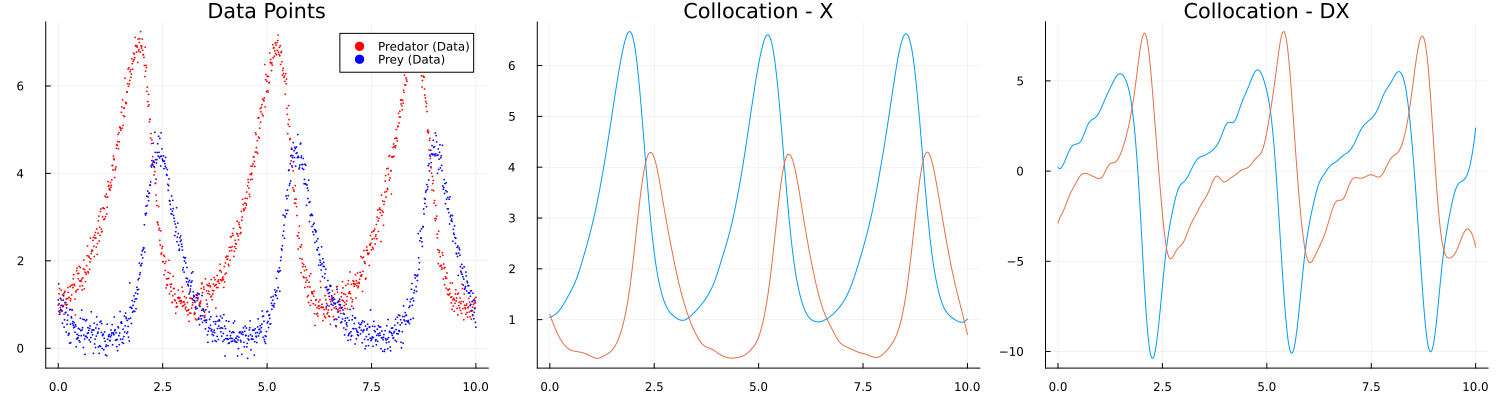

In [11]:
using DataDrivenDiffEq, ModelingToolkit, OrdinaryDiffEq
using LinearAlgebra
# Create the problem using a gaussian kernel for collocation(選点法)
full_problem = ContinuousDataDrivenProblem(data, t, DataDrivenDiffEq.GaussianKernel())
#
# 第1グラフ: Lotka-Volterra Data
p1 = scatter(t, [data[1, i] for i in 1:length(t)], label = "Predator (Data)", markercolor = :red, markersize = 1, markerstrokecolor = :red, markerstrokewidth = 0.5, title = "Data Points", xlabel = "Time", ylabel = "Population", legend = :topright)
scatter!(t, [data[2, i] for i in 1:length(t)], label = "Prey (Data)", markercolor = :blue, markersize = 1, markerstrokecolor = :blue, markerstrokewidth = 0.5)
#p1 = plot(t, transpose(Xₙ), xlabel = "t", ylabel = "x(t), y(t)", label = ["x" "y"], color=[:blue :red], lw=2, legend=:outertopright, title="Lotka-Volterra Model Data")
# 第2グラフ: Collocation with Gaussian Kernel - X
p2 = plot(full_problem.t, full_problem.X', title="Collocation - X", legend=false)
# 第3グラフ: Collocation with Gaussian Kernel - DX
p3 = plot(full_problem.t, full_problem.DX', title="Collocation - DX", legend=false)
# 3つのグラフを一覧表示
plot(p1, p2, p3, layout = (1, 3), size = (1500, 400))

データ設定と問題定義のグラフ出力

In [12]:
savefig("DataDriven_LotkaVolterraProblem.png")

"c:\\Users\\kmako\\Dropbox\\JuliaDocs\\6_Modelbased_DeepLearning\\Lotka_Volterra\\DataDriven_LotkaVolterraProblem.png"

データ駆動発見のためのSINDy（Sparse Identification of Nonlinear Dynamical systems:非線形力学のスパース同定）アプローチを用いる。
SINDyアプローチは、システムの動的挙動を記述する微分方程式を観測データから直接識別できるように設計されている。
最大7次の多項式の基底関数と余弦関数のセットとして、基底を生成する。
正則化パラメータλを設定する：exp10.(-7:0.1:5)は、10^(−7)～10^5までの値を0.1の刻み幅で生成し、Float32型に変換する。λはモデルのスパース性制御のために用いる。
STLSQ（Sequential Threshold Least Squares）とλ値を用いて、スパース解探索のための最適化器を作成する。(※)計算時間2分間

In [16]:
#using Optim
using DiffEqFlux, Flux
using JLD2, FileIO
using Statistics
using DelimitedFiles
using DataFrames
using OptimizationOptimisers
using ComponentArrays
#
full_problem = ContinuousDataDrivenProblem(data, t, DataDrivenDiffEq.GaussianKernel())
# Create a Basis
# 状態変数とパラメータを定義
@variables u[1:2] p[1:4]
#
# Generate the basis functions, multivariate polynomials up to deg 6 and sine, cosine function
#b = Num[polynomial_basis(u, 2)]
#b = Num[polynomial_basis(u, 5); sin.(u)]
b = Num[u[1];u[2];u[1]*u[2]]
basis = Basis(b, u)
#println(basis)
#
# Create the thresholds which should be used in the search process
λ = (exp10.(-10:0.1:5))
# Create an optimizer for the SINDy problem
opt = STLSQ(λ)

# SINDy approach execution
# Best result so far
full_res = solve(full_problem, basis, opt, maxiter = 10000, progress = true, denoise = true, normalize = true)
system = get_basis(full_res)
params = get_parameter_map(system)
println(system) 
println(params)
println(full_res)

Model ##Basis#262 with 2 equations
States : u[1] u[2]
Parameters : 6
Independent variable: t
Equations
Differential(t)(u[1]) = p₁*u[1] + p₂*u[2] + p₃*u[1]*u[2]
Differential(t)(u[2]) = p₄*u[1] + p₅*u[2] + p₆*u[1]*u[2]

Pair{SymbolicUtils.BasicSymbolic{Real}, Float64}[p₁ => 1.4663123637, p₂ => -0.1723894414, p₃ => -0.9158496666, p₄ => 0.0436347428, p₅ => -2.8786634351, p₆ => 0.9198623234]
"DataDrivenSolution{Float64}" with 2 equations and 6 parameters.
Returncode: Success
Residual sum of squares: 211.2600068158041


Model ##Basis#1361 with 2 equations
States : u[1] u[2]
Parameters : 6
Independent variable: t
Equations
Differential(t)(u[1]) = p₁*u[1] + p₂*u[2] + p₃*u[1]*u[2]
Differential(t)(u[2]) = p₄*u[1] + p₅*u[2] + p₆*u[1]*u[2]

Pair{Sym{Real, Base.ImmutableDict{DataType, Any}}, Float64}[p₁ => 1.4663123637, p₂ => -0.1723894414, p₃ => -0.9158496666, p₄ => 0.0436347428, p₅ => -2.8786634351, p₆ => 0.9198623234]
"DataDrivenSolution{Float64}" with 2 equations and 6 parameters.
Returncode: Success
Residual sum of squares: 211.26000681580496

データ推定結果の各種統計量

In [17]:
println(system) 

Model ##Basis#262 with 2 equations
States : u[1] u[2]
Parameters : 6
Independent variable: t
Equations
Differential(t)(u[1]) = p₁*u[1] + p₂*u[2] + p₃*u[1]*u[2]
Differential(t)(u[2]) = p₄*u[1] + p₅*u[2] + p₆*u[1]*u[2]



In [13]:
println(params) 

Pair{SymbolicUtils.BasicSymbolic{Real}, Float64}[p₁ => 1.4663123637, p₂ => -0.1723894414, p₃ => -0.9158496666, p₄ => 0.0436347428, p₅ => -2.8786634351, p₆ => 0.9198623234]


In [14]:
println(full_res)

"DataDrivenSolution{Float64}" with 2 equations and 6 parameters.
Returncode: Success
Residual sum of squares: 211.26000681580493


SINDyアルゴリズム結果の決定係数（R²）、赤池情報量基準（AIC）、ベイズ情報量基準（BIC）、対数尤度、および自由度（DoF）を計算し、表形式で出力する。

In [19]:
using DataFrames, CSV

# 評価指標の計算結果
values_ordered = [r2(full_res), dof(full_res), loglikelihood(full_res), aic(full_res), bic(full_res)]

# 評価指標の名前（指定された順番で）
metric_names_ordered = [:R2, :DoF, :LogLikelihood, :AIC, :BIC]

# 新しいDataFrameを作成し、指定された順番で各指標を列に割り当てる
# DataFrameのコンストラクターを利用して、各列に値を直接割り当てる
SINDy_metrics = DataFrame(
    R2 = [values_ordered[1]],
    DoF = [values_ordered[2]],
    LogLikelihood = [values_ordered[3]],
    AIC = [values_ordered[4]],
    BIC = [values_ordered[5]]
)

# 作成されたDataFrameを表示
println("SINDy-based Model Evaluation Metrics:")
println(SINDy_metrics)

# 結果をCSVファイルに保存
CSV.write("SINDy_metrics.csv", SINDy_metrics)

SINDy-based Model Evaluation Metrics:
1×5 DataFrame
 Row │ R2        DoF      LogLikelihood  AIC       BIC      
     │ Float64   Float64  Float64        Float64   Float64  
─────┼──────────────────────────────────────────────────────
   1 │ 0.992844      6.0        2247.81  -4483.63  -4450.02


"SINDy_metrics.csv"

In [24]:
basis = get_basis(full_res)
println(basis)

Model ##Basis#1074 with 2 equations
States : u[1] u[2]
Parameters : 6
Independent variable: t
Equations
Differential(t)(u[1]) = p₁*u[1] + p₂*u[2] + p₃*u[1]*u[2]
Differential(t)(u[2]) = p₄*u[1] + p₅*u[2] + p₆*u[1]*u[2]



In [25]:
get_parameter_map(basis)

6-element Vector{Pair{SymbolicUtils.BasicSymbolic{Real}, Float64}}:
 p₁ => 1.4663123637
 p₂ => -0.1723894414
 p₃ => -0.9158496666
 p₄ => 0.0436347428
 p₅ => -2.8786634351
 p₆ => 0.9198623234

SINDyによるシステム同定結果（状態変数とその傾き）のグラフを出力

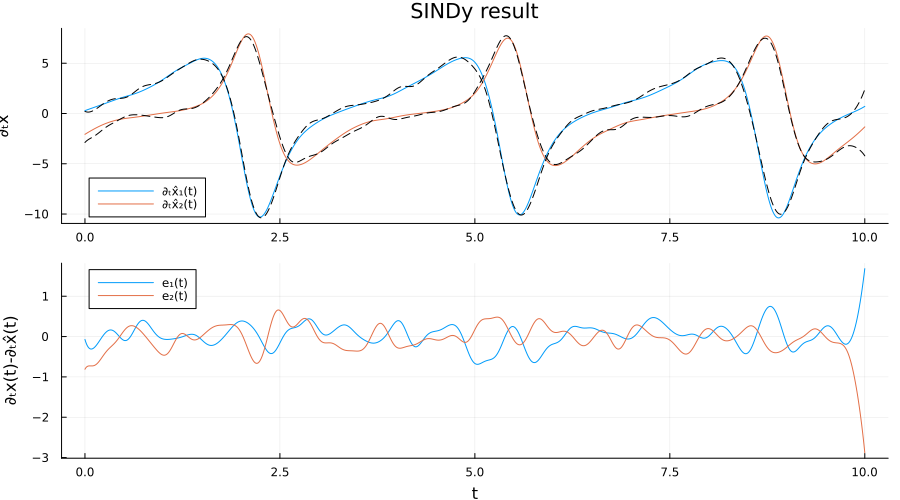

"d:\\Dropbox\\JuliaDocs\\6_Modelbased_DeepLearning\\Lotka_Volterra\\SINDy_LotkaV_Result.png"

In [18]:
p0 = plot(full_res, title="SINDy result", size = (900, 500))
display(p0)
savefig("SINDy_LotkaV_Result.png")

ODE方程式の定義

In [19]:
# System of ODEsの定義
function ddsystem!(du, u, p, t)
    du[1] = dx = p[1]*u[1] + p[2]*u[2] + p[3]*u[1]*u[2]
    du[2] = dy = p[4]*u[1] + p[5]*u[2] + p[6]*u[1]*u[2]
end

u0 = [1.0; 1.0]
tspan = (0.0, T)
datap = [1.4663123637, -0.1723894414, -0.9158496666, 0.0436347428, -2.8786634351,  0.9198623234]
dataprob = ODEProblem(ddsystem!, u0, tspan, datap)
datasol = solve(dataprob, Tsit5())



retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 32-element Vector{Float64}:
  0.0
  0.07863243540842463
  0.23811170675130647
  0.44005856683274125
  0.7018730774980264
  0.9810018293308432
  1.3227917152848847
  1.6740454951598025
  2.049306106558684
  2.342902079647162
  ⋮
  7.116178689752623
  7.560981370554894
  7.963077855088264
  8.501442789451072
  8.848086537523002
  9.14930807565807
  9.480479920949167
  9.737155893880027
 10.0
u: 32-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [1.036684221145695, 0.8615558057028737]
 [1.1524252626153397, 0.6453579188970217]
 [1.3789787646524057, 0.4652952353206]
 [1.8215843547239576, 0.33616107973671044]
 [2.520148359837634, 0.28500168407998305]
 [3.7698059956672876, 0.33065425080082167]
 [5.440395452009415, 0.6227595186355697]
 [6.323218455101231, 1.912120614746817]
 [4.380339598058044, 3.7599404709899624]
 ⋮
 [1.3402925269425243, 0.6308478829841188]
 [2.072500396943529, 0.37152479453607384]
 [3.25893300228775,

プロット

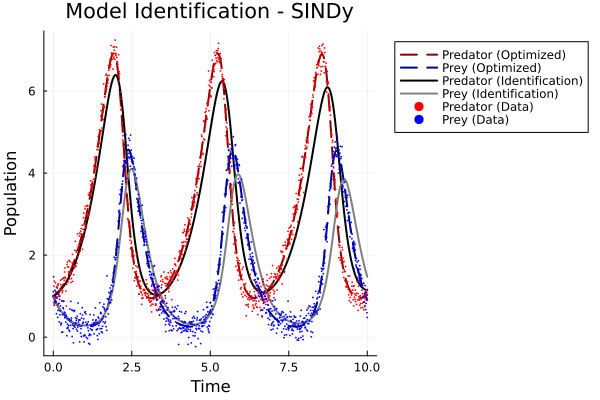

"d:\\Dropbox\\JuliaDocs\\6_Modelbased_DeepLearning\\Lotka_Volterra\\LtkV_SINDy_Data.png"

In [20]:
#
optprob = ODEProblem(system!, u0, tspan, result_bfgs.minimizer)
optsol = solve(optprob, Tsit5())

# 最適解のプロット（線の色を濃い赤色と藍色の点線で指定）
p1 = plot(t, [optsol(t)[1] for t in t], label = "Predator (Optimized)", title = "Model Estimation - SINDy", xlabel = "Time", ylabel = "Population", legend = :outertopright, linewidth = 2, linecolor = :darkred,linestyle=:dash)
plot!(t, [optsol(t)[2] for t in t], label = "Prey (Optimized)", linewidth = 2, linecolor = :navy,linestyle=:dash,)

# データ同定解のプロット（線の色を銅色と灰色の実線で指定）
plot!(t, [datasol(t)[1] for t in t], label = "Predator (Identification)", title = "Model Identification - SINDy", xlabel = "Time", ylabel = "Population", legend = :outertopright, linewidth = 2, linecolor = :copper)
plot!(t, [datasol(t)[2] for t in t], label = "Prey (Identification)", linewidth = 2, linecolor = :grey)

# データポイントの追加（マーカー色を赤色と青色に指定、枠線も同じ色で指定）
scatter!(t, [data[1, i] for i in 1:length(t)], label = "Predator (Data)", markercolor = :red, markersize = 1, markerstrokecolor = :red, markerstrokewidth = 0.5)
scatter!(t, [data[2, i] for i in 1:length(t)], label = "Prey (Data)", markercolor = :blue, markersize = 1, markerstrokecolor = :blue, markerstrokewidth = 0.5)

plot(p1,layout = (1, 1), size = (700, 400))
display(p1)
#
savefig("LtkV_SINDy_Data.png")

位相図の描画。

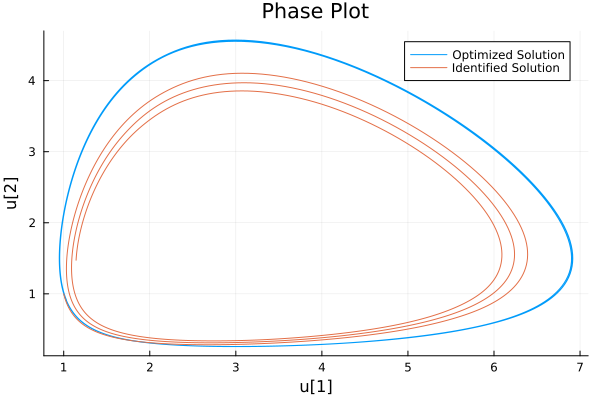

"d:\\Dropbox\\JuliaDocs\\6_Modelbased_DeepLearning\\Lotka_Volterra\\LtkV_SINDy_Phase_Plot.png"

In [34]:
# 位相図のプロット
p2 = plot(optsol, vars=(1,2), label="Optimized Solution", title="Phase Plot", xlabel="Predator", ylabel="Prey")
plot!(datasol, vars=(1,2), label="Identified Solution")

# データポイントの追加 (実際のデータポイントの追加方法は、データの形式により異なります)
# 以下は、データポイントが data = [prey, predator] の形式である場合の例
# data = [[1.0, 2.0], [1.5, 1.8], ...] のように定義されていると仮定
# 最終的なプロットの表示
display(p2)
#
savefig("LtkV_SINDy_Phase_Plot.png")
